## CLASSIGY NEW DATA


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

import glob
import logging
from pathlib import Path

import arviz as az
import cloudpickle
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sqlalchemy import create_engine

from ppcluster import setup_logger
from ppcluster.config import ConfigManager
from ppcluster.database import (
    get_dic_analysis_by_ids,
    get_dic_analysis_ids,
    get_dic_data,
    get_image,
)
from ppcluster.mcmc import (
    assign_spatial_priors,
    compute_posterior_assignments,
    plot_1d_velocity_clustering,
)
from ppcluster.preprocessing import (
    apply_dic_filters,
    preproc_features,
)
from ppcluster.roi import PolygonROISelector
from ppcx_pymc_inference_func import (
    close_small_holes,
    compute_cluster_statistics_simple,
    create_2d_grid,
    map_grid_to_points,
    plot_1d_velocity_clustering_simple,
    plot_cluster_labels_on_image,
    remove_small_grid_components,
    split_disconnected_components,
)

logger = setup_logger(
    level=logging.DEBUG,
    name="ppcx",
    force=True,
)

# Load configuration
config = ConfigManager()
db_engine = create_engine(config.db_url)

In [2]:
date = "2024-08-28"
camera_name = "PPCX_Tele"
output_dir = Path("output") / f"{camera_name}_PyMC"

# Load posterior and scaler
PRIOR_STRENGTH = 0.4
reference_start_date = "2024-08-23"
reference_end_date = "2024-08-28"
posterior_base_name = (
    f"PPCX_mcmc_{camera_name}_pooled_{reference_start_date}_{reference_end_date}"
)
idata = az.from_netcdf(output_dir / f"{posterior_base_name}_posterior.idata.nc")
scaler = joblib.load(output_dir / f"{posterior_base_name}_scaler.joblib")

In [3]:
# Get DIC data
dic_ids = get_dic_analysis_ids(db_engine, camera_name=camera_name, reference_date=date)
if len(dic_ids) == 0:
    raise ValueError("No DIC analyses found for the given criteria")
elif len(dic_ids) > 1:
    logger.warning(
        "Multiple DIC analyses found for the given criteria. Using the first one."
    )
dic_id = dic_ids[0]

dic_analyses = get_dic_analysis_by_ids(db_engine=db_engine, dic_ids=[dic_id])
master_image_id = dic_analyses["master_image_id"].iloc[0]
img = get_image(
    master_image_id,
    camera_name=camera_name,
    config=config,
)
df = get_dic_data(dic_id, config=config)
df = apply_dic_filters(
    df,
    filter_outliers=config.get("dic.filter_outliers"),
    tails_percentile=config.get("dic.tails_percentile"),
)

selector = PolygonROISelector.from_file(config.get("data.roi_path"))
df = selector.filter_dataframe(df, x_col="x", y_col="y")
logger.info(f"Data shape after filtering: {df.shape}")

2025-09-15 12:21:01 | [database.py -> get_dic_analysis_ids], line 179 - [INFO    ] Found 1 DIC analyses matching criteria
2025-09-15 12:21:01 | [preprocessing.py -> apply_dic_filters], line 117 - [INFO    ] Starting DIC filtering pipeline with 5251 points
2025-09-15 12:21:01 | [preprocessing.py -> filter_outliers_by_percentile], line 167 - [INFO    ] Percentile filtering: 5251 -> 5145 points (removed 106 outliers)
2025-09-15 12:21:01 | [preprocessing.py -> filter_by_min_velocity], line 195 - [INFO    ] Min velocity filtering: 5145 -> 5145 points (removed 0 points below 0.0)
2025-09-15 12:21:01 | [preprocessing.py -> apply_dic_filters], line 137 - [INFO    ] DIC filtering pipeline completed: 5251 -> 5145 points (removed 106 total)
2025-09-15 12:21:01 | [3460896058.py -> <module>], line 27 - [INFO    ] Data shape after filtering: (2295, 5)


Filtered 5145 points to 2295 points inside polygon


In [4]:
# Prepare new data
variables_names = config.get("clustering.variables_names")
df_features = preproc_features(df)
X = df_features[variables_names].values
X_scaled = scaler.transform(X)

# # Assign spatial priors
sector_files = sorted(glob.glob(config.get("data.sector_prior_pattern")))
sector_selectors = [PolygonROISelector.from_file(f) for f in sector_files]
prior_probs = assign_spatial_priors(df, sector_selectors, prior_strength=PRIOR_STRENGTH)

2025-09-15 12:21:01 | [mcmc.py -> assign_spatial_priors], line 49 - [INFO    ] Sector 0: 297 points with strong prior
2025-09-15 12:21:01 | [mcmc.py -> assign_spatial_priors], line 49 - [INFO    ] Sector 1: 407 points with strong prior
2025-09-15 12:21:01 | [mcmc.py -> assign_spatial_priors], line 49 - [INFO    ] Sector 2: 440 points with strong prior
2025-09-15 12:21:01 | [mcmc.py -> assign_spatial_priors], line 49 - [INFO    ] Sector 3: 963 points with strong prior


2025-09-15 12:21:01 | [2557201729.py -> <module>], line 24 - [INFO    ] Results saved to output/PPCX_Tele_PyMC/PPCX_mcmc_PPCX_Tele_2024-08-28_dic-634_results.pkl


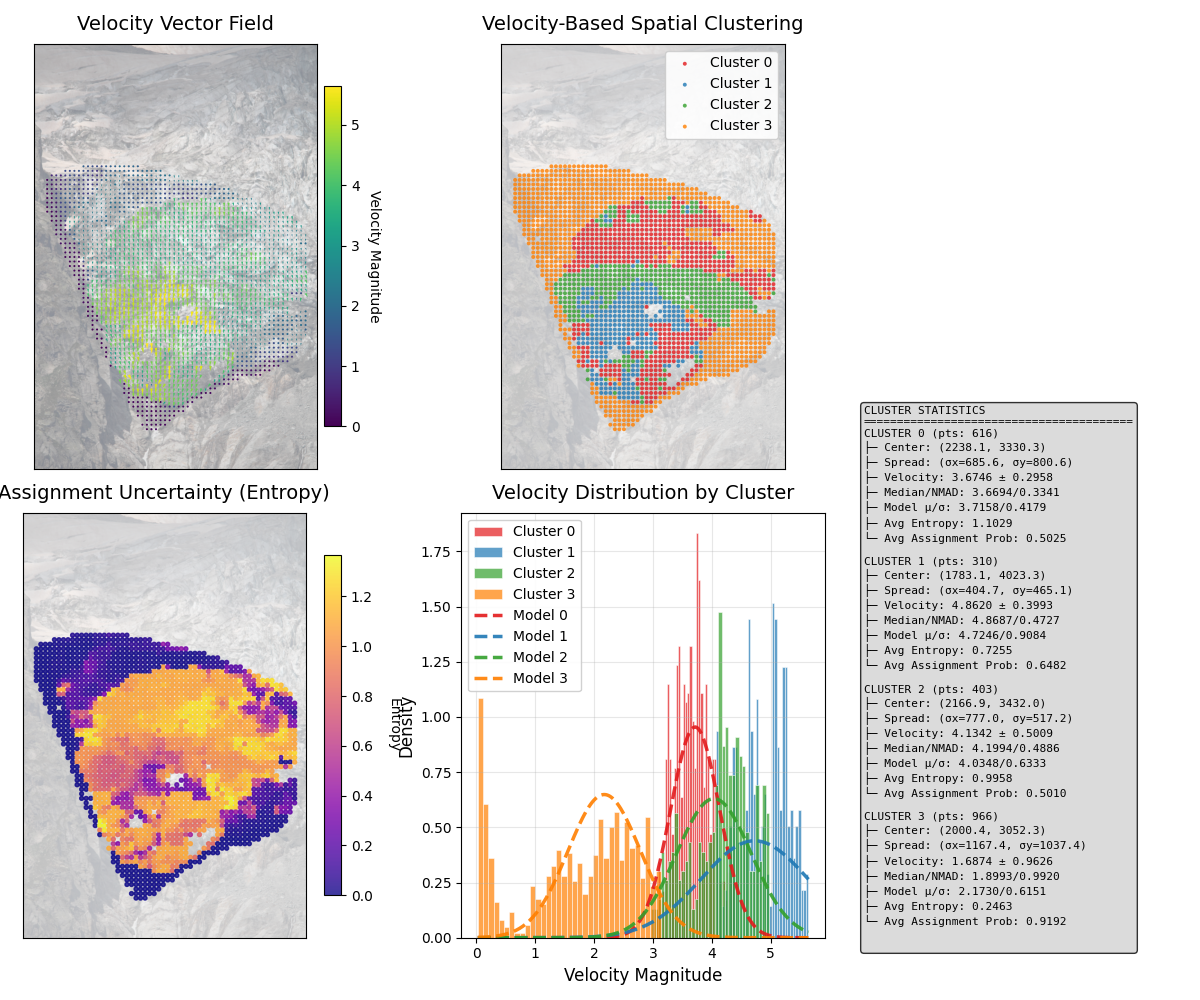

In [5]:
# compute assignments for new single-day data (fast option using posterior mean)
posterior_probs, cluster_pred, entropy = compute_posterior_assignments(
    idata, X_scaled, prior_probs, use_posterior_mean=True
)

# Save results to pickle
outbasepath = output_dir / f"PPCX_mcmc_{camera_name}_{date}_dic-{dic_id}_results"
output_dir.mkdir(parents=True, exist_ok=True)
with open(outbasepath.with_suffix(".pkl"), "wb") as f:
    cloudpickle.dump(
        {
            "data": df,
            "df_features": df_features,
            "var_names": variables_names,
            "features_scaled": X_scaled,
            "posterior_probs": posterior_probs,
            "cluster_pred": cluster_pred,
            "entropy": entropy,
            "scaler": scaler,
            "idata": idata,
        },
        f,
    )
    logger.info(f"Results saved to {outbasepath.with_suffix('.pkl')}")

# Plot results
fig, uncertainty, stats = plot_1d_velocity_clustering(
    df_features,
    img,
    idata=idata,
    cluster_pred=cluster_pred,
    posterior_probs=posterior_probs,
    scaler=scaler,
)
fig.savefig(
    outbasepath.with_suffix(".png"),
    dpi=300,
    bbox_inches="tight",
)

## Post processing


In [6]:
# Evaluate median entropy to discard bad day
median_entropy_treshold = 0.6
median_entropy = np.median(entropy)


In [ ]:
X, Y, label_grid = create_2d_grid(
    x=df["x"].to_numpy(), y=df["y"].to_numpy(), labels=cluster_pred, grid_spacing=None
)
logger.info(
    f"Initial grid shape: {label_grid.shape}, NaN cells: {np.isnan(label_grid).sum()}"
)

# Remove small cluster components
remove_small_min_size = [20, 5]
connectivity = 4
cleaned_grid = label_grid.copy()
for min_size in remove_small_min_size:
    cleaned_grid = remove_small_grid_components(
        cleaned_grid, min_size=min_size, connectivity=connectivity
    )
logger.debug(
    "After removing small components: shape=%s nan=%d unique_labels=%s",
    cleaned_grid.shape,
    int(np.isnan(cleaned_grid).sum()),
    np.unique(cleaned_grid[~np.isnan(cleaned_grid)])
    if np.any(~np.isnan(cleaned_grid))
    else [],
)

# Close small holes
cleaned_grid = close_small_holes(
    cleaned_grid,
    max_hole_size=50,
    connectivity=4,
    require_single_neighbor=True,
)
nan_after = int(np.isnan(cleaned_grid).sum())
unique_after = (
    np.unique(cleaned_grid[~np.isnan(cleaned_grid)])
    if np.any(~np.isnan(cleaned_grid))
    else []
)
logger.info(
    "After close_small_holes: NaN cells=%d unique_labels=%s", nan_after, unique_after
)

# split disconnected pieces so every connected patch has its own label
split_grid, split_mapping = split_disconnected_components(
    cleaned_grid, connectivity=8, start_label=0
)

# Map label grid back to points
point_labels_cleaned = map_grid_to_points(
    X, Y, split_grid, df, x_col="x", y_col="y", nan_fill=-1
)
cluster_pred_cleaned = point_labels_cleaned.astype(int)

2025-09-15 12:32:08 | [1950743727.py -> create_2d_grid], line 25 - [INFO    ] Estimated grid spacing: 64.00


2025-09-15 12:32:08 | [2893897307.py -> <module>], line 4 - [INFO    ] Initial grid shape: (59, 58), NaN cells: 1127
2025-09-15 12:32:08 | [2893897307.py -> <module>], line 16 - [DEBUG   ] After removing small components: shape=(59, 58) nan=1128 unique_labels=[0. 1. 2. 3.]
2025-09-15 12:32:08 | [1950743727.py -> close_small_holes], line 257 - [DEBUG   ] hole 1: size=13 filled with label=3.0 (require_single_neighbor=True)
2025-09-15 12:32:08 | [1950743727.py -> close_small_holes], line 196 - [DEBUG   ] hole 2: size=215 skipped (size>50)
2025-09-15 12:32:08 | [1950743727.py -> close_small_holes], line 196 - [DEBUG   ] hole 3: size=510 skipped (size>50)
2025-09-15 12:32:08 | [1950743727.py -> close_small_holes], line 257 - [DEBUG   ] hole 4: size=1 filled with label=3.0 (require_single_neighbor=True)
2025-09-15 12:32:08 | [1950743727.py -> close_small_holes], line 257 - [DEBUG   ] hole 5: size=1 filled with label=2.0 (require_single_neighbor=True)
2025-09-15 12:32:08 | [1950743727.py -> c

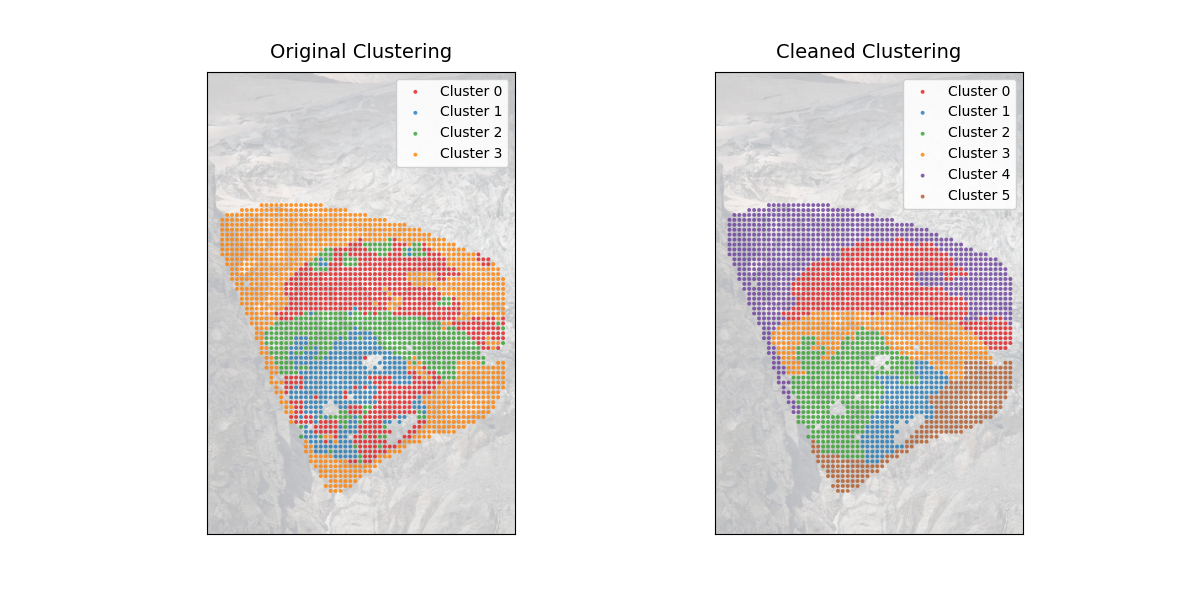

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plot_cluster_labels_on_image(
    df_features, img, cluster_pred, title="Original Clustering", ax=axes[0]
)
plot_cluster_labels_on_image(
    df_features, img, cluster_pred_cleaned, title="Cleaned Clustering", ax=axes[1]
);

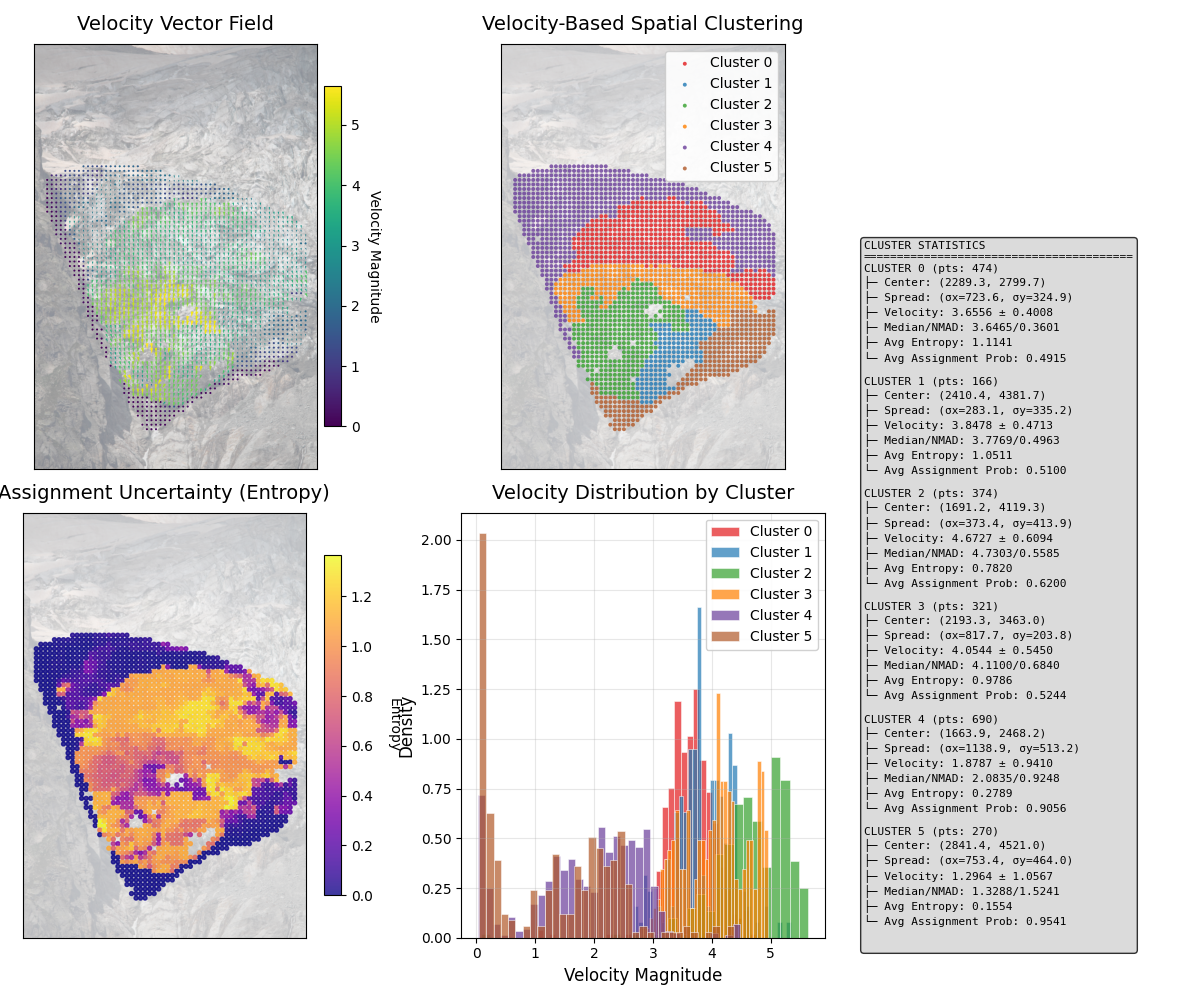

In [ ]:
cluster_stats = compute_cluster_statistics_simple(
    df_features,
    cluster_pred=cluster_pred_cleaned,
    posterior_probs=posterior_probs,
)
cluster_stats = pd.DataFrame(cluster_stats).T


fig, uncertainty, stats = plot_1d_velocity_clustering_simple(
    df_features,
    img,
    cluster_pred=cluster_pred_cleaned,
    posterior_probs=posterior_probs,
)
fig.savefig(
    outbasepath.with_name(outbasepath.name + "_cluster_cleaned.png"),
    dpi=300,
    bbox_inches="tight",
)

In [27]:
cluster_stats

count       x_mean       y_mean        x_std       y_std  velocity_mean  \
0  474.0  2289.282700  2799.662447   723.563597  324.932275       3.655644   
1  166.0  2410.409639  4381.686747   283.144437  335.187843       3.847756   
2  374.0  1691.208556  4119.272727   373.406882  413.902344       4.672697   
3  321.0  2193.345794  3462.978193   817.662580  203.805179       4.054431   
4  690.0  1663.907246  2468.173913  1138.948283  513.155596       1.878679   
5  270.0  2841.362963  4521.007407   753.387870  464.037219       1.296413   

   velocity_std  velocity_median  velocity_nmad  avg_entropy  \
0      0.400751         3.646538       0.360108     1.114056   
1      0.471297         3.776915       0.496268     1.051118   
2      0.609437         4.730315       0.558540     0.781964   
3      0.545023         4.110021       0.684023     0.978630   
4      0.940995         2.083503       0.924772     0.278929   
5      1.056715         1.328776       1.524064     0.155373   

   avg_assignment_prob  
0             0.491477  
1             0.510013  
2             0.620027  
3             0.524351  
4             0.905580  
5             0.954058

In [ ]:
# Assign